# Paper contribution

In this paper Mikolov et. al. present a novel method for learning continues word representations using an iterative NNLM approach. They also discovered that learned word representations have some interesting properties (`v("king") - v("man") + v("woman") = v("queen")`, where `=` means the closest in terms of cosine distance) and propose a new dataset for word embeddings quality assessments. They present two architectures for learning word representations -- CBOW and Skip-gram.

# CBOW model

Continuous bag of words model. The learning process goes like this -- we take words one after another, take it's context (`C` words from past and `C` words from future. `C` is a hyperparameter). We take context words embeddings and prject it on a hidden layer `H` (we average these embeddings). Then we take this averaged embedding, take an inner product with all words' embeddings and take softmax to obtain "probabitilies" for each word to be the center of the current context.

Since the original words are encoded using 1-hot encoding, the "projections" is simply matrix row (or column) selections.

# Skip-gram

Pretty much the same thing, but instead of predicting word by its context it predicts context by a word.

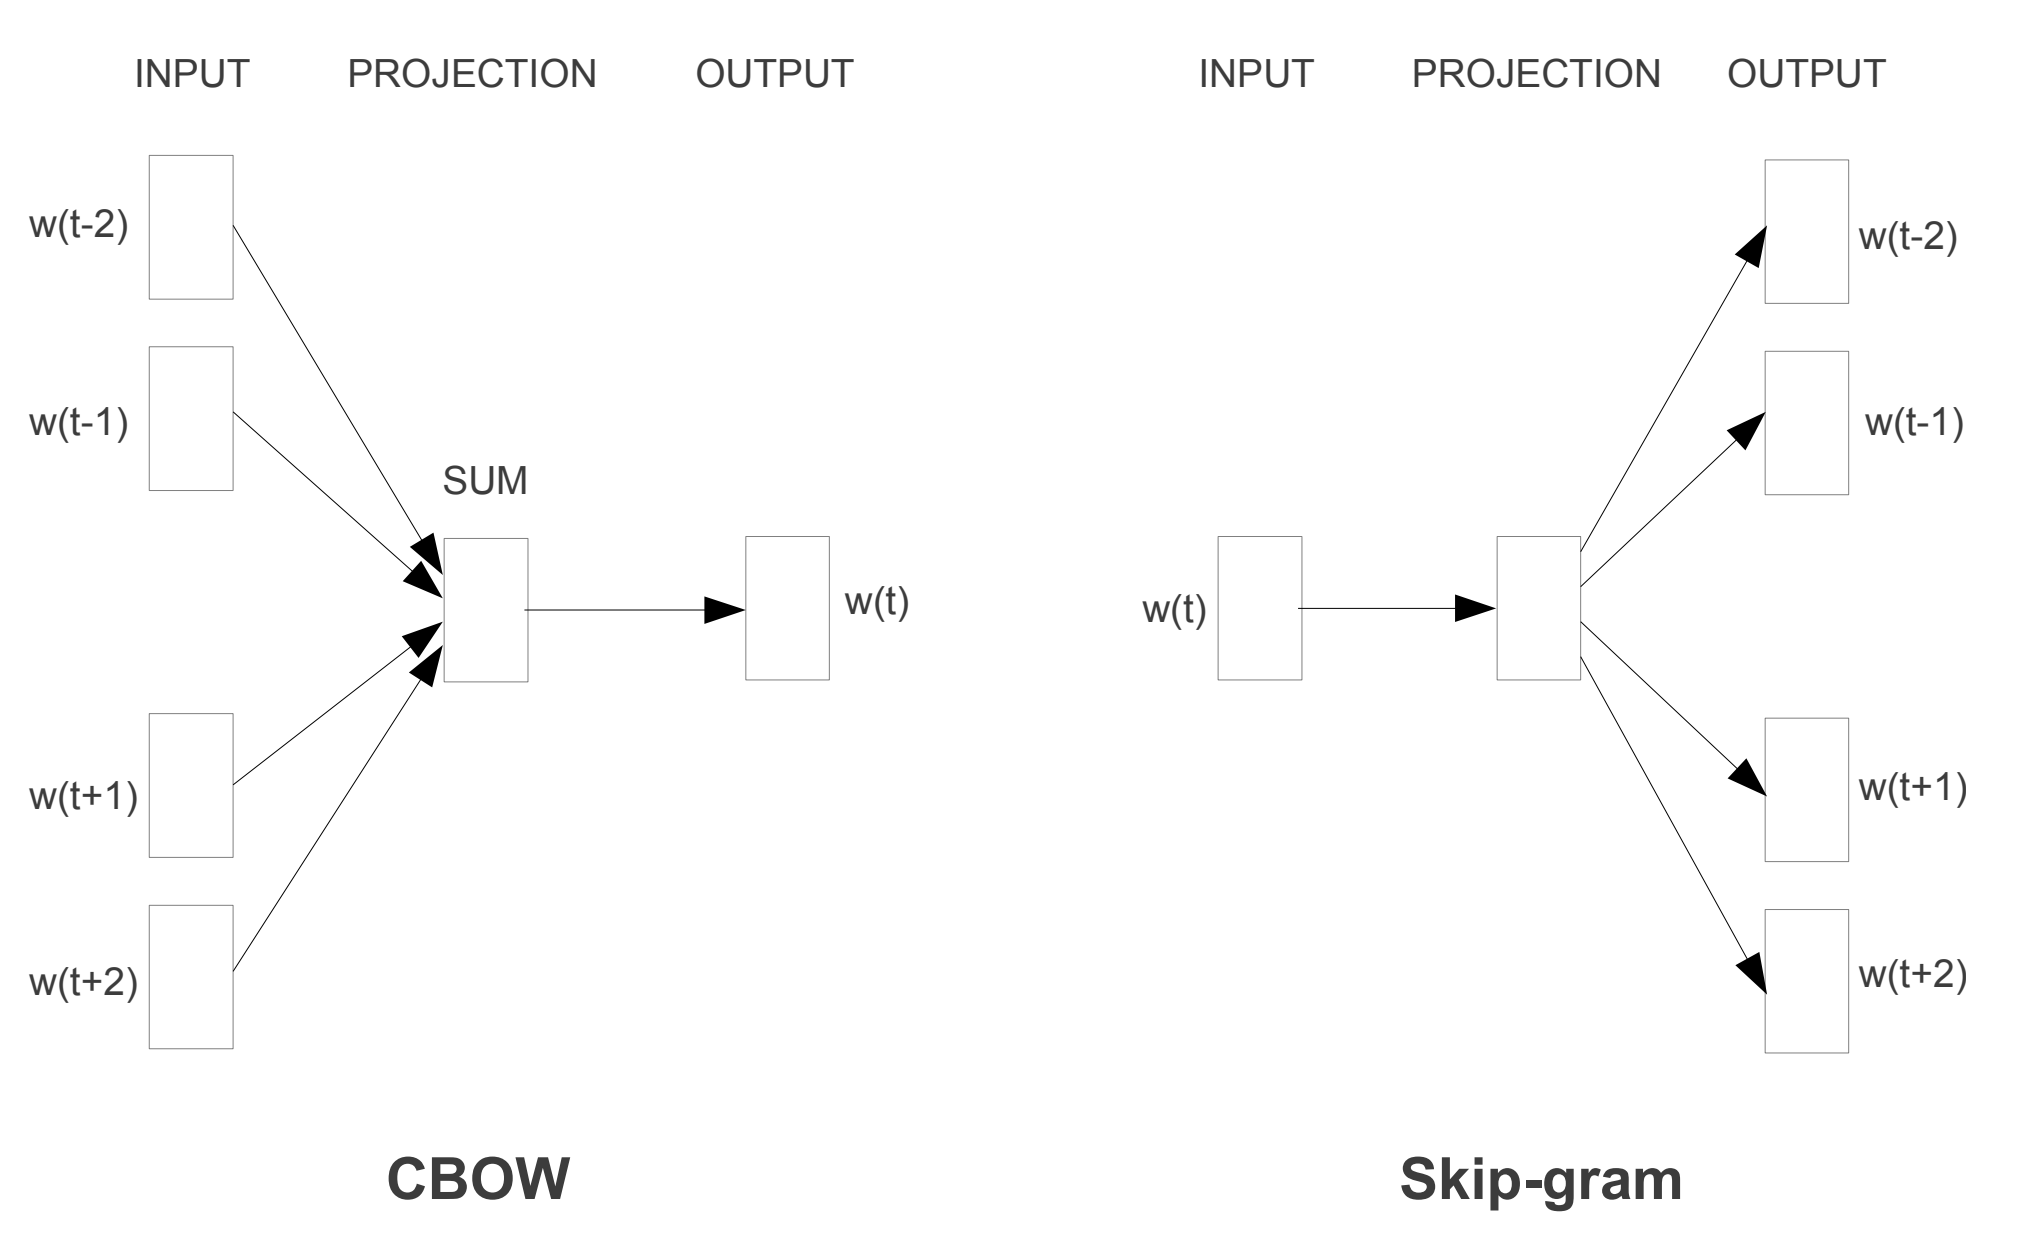

# Training

Thus, for CBOW, we get:

$$
p(w_{O}|w_{I}) = \frac{\exp(v_{w_{O}}^T\cdot u_{w_{I}})}{\Sigma_{w}\exp(v_{w}^T\cdot u_{w_{I}})}
$$

The resulting word embedding is 

$$
v_{w} + u_{w}
$$

Where $u_{w}$ is word's embedding when it acts as a context word, $v_{w}$ when it acts as a center word.

The objective function is maximum log-likelihood:

$$
L = \log\left(\Pi_{t=1}^T \Pi_{j=-C, j\neq0}^{C} p(w_{t}|w_{t+j})\right) = \Sigma_{t=1}^T \Sigma_{j=-C, j\neq0}^C \log \; p(w_{t}|w_{t+j})
$$

For Skip-gram we simply reverse $w_O$ and $w_I$, changing indexes a bit in the last equation.

Instead of calculating vanilla softmax, authors use hierachical softmax, which boosts the speed of the calculation of $p(w_t|w_{t+j})$ from $|V|$ to $\log |V|$.

The probabilies are then computed like this (writing for skip-gram this time):

$$
p(w|w_I) = \Pi_{j=1}^{L-1} \sigma\left([n(w_O, j+1) = ch(n(w, j))] \cdot u_{n(w_O, j)}^T \cdot v_{w_I}\right)
$$

(see paper for more details, but this is simply a fuzzy oblique decision tree)

# Negative sampling

Actually, hierarchical softmax was used in the first paper, but in the second authors proposed a new (ish) technique called negative sampling.

The idea here is we can pick a central word, a word from its context, and a few words not from the context. The model should maximize co-occurance probability of the central word with the former, while minimizing co-occurance probability with the latter ones. Formally, we have (since we are dealing with skip-gram model here, $w_I$ is a central word, $w_O$ is a word from its context):

$$
\log p(w_O|w_I) + \Sigma_{i=1, w_i ~ P_n(w)}^k \log(1 - p(w|w_I)) = \log\sigma(v_{w_I}^T\cdot u_{w_O}) + \Sigma_{i=1, w_i ~ P_n(w)}^k \log \sigma(-v_{w_I}^T\cdot u_{w})
$$

This term is used istead of every $p(w_O|w_I)$ in the original loss function.

It's right to think about it as trying to distinguish a real context word $w_O$ from a noise drawn using $P_n(w)$. Empirically, it was found that $U(w)^{3/4}/Z$ gives good results.

# Subsampling of frequent words

We need some way of balancing our imbalanced dataset -- there are some very frequent words ("a", "the", etc.) and some rare words. Authors propose a simple empirically chosen heuristic: each word in a dataset is discarded with probability

$$
P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}
$$

, where $f(w_i)$ is the frequency of the word $w_i$. $t$ is typically around $10^{-5}$.

# Learning phrases

The paper also presents a data-driven approach to learning phrases, but I don't think it's that intersting...

# To the code...

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [178]:
# TODO
class Cbow(nn.Module):
    def __init__(self):
        super(Cbow, self).__init__()
        pass

class SkipGram(nn.Module):
    def __init__(self, V, D):
        super(SkipGram, self).__init__()
        self.emb_center = nn.Embedding(V, D)
        self.emb_context = nn.Embedding(V, D)
    
    def forward(self, center_word, context_word, neg_examples):
        batch_size = len(center_word)
        assert len(context_word) == batch_size and len(neg_examples) == batch_size
        
        center_word = center_word.view(-1, 1)
        context_word = context_word.view(-1, 1)
        
        center_embeddings = self.emb_center(center_word)
        context_embeddings = self.emb_context(context_word)
        neg_embeddings = self.emb_context(neg_examples)
        
        positive = torch.bmm(center_embeddings, context_embeddings.permute(0, 2, 1)).squeeze()
        positive = F.logsigmoid(positive)
        # b x 1 x D
        # b x k x D
        # b x 1 x k
        negative = torch.bmm(center_embeddings, neg_embeddings.permute(0, 2, 1)).squeeze()
        negative = torch.sum(F.logsigmoid(-negative), dim=1)
        
        return -(positive + negative)
    
    def get_emb(self, word_id):
        if not torch.is_tensor(word_id):
            word_id = torch.LongTensor([word_id])
        return self.emb_center(word_id) + self.emb_context(word_id)

In [67]:
def build_vocab(texts):
    word_ids = {}
    word_freqs = {}
    free_id = 0
    for text in texts:
        for word in text:
            if word not in word_ids:
                word_ids[word] = free_id
                word_freqs[word] = 1
                free_id += 1
            else:
                word_freqs[word] += 1
    for word in word_freqs:
        word_freqs[word] = word_freqs[word] / len(word_ids)
    return word_ids, word_freqs

In [149]:
# Subsampling of frequent words

import random

def subsample_frequent(texts, vocab, word_freqs, t=1e-4):
    out_texts = []
    for text in texts:
        out_text = []
        for word in text:
            x = random.uniform(0, 1)
            p = 1 - np.sqrt(t/word_freqs[word])
            if x > p:
                out_text.append(word)
        out_texts.append(out_text)
    return out_texts

In [150]:
def negative_samples_generator(word_freqs):
    probs = np.array(list(word_freqs.values())) ** (3/4)
    probs = probs / probs.sum()
    while True:
        yield np.argmax(np.random.multinomial(1, probs))

In [25]:
def positive_samples_generator(texts, word_ids, C):
    for text in texts:
        for i in range(len(text)):
            for j in range(max(0, i - C), min(len(text), i + C + 1)):
                if j != i:
                    yield (word_ids[text[i]], word_ids[text[j]])

In [87]:
import itertools

class ExamplesDataset(torch.utils.data.Dataset):
    def __init__(self, texts, C, k):
        super(ExamplesDataset, self).__init__()
        self.vocab, self.freqs = build_vocab(texts)
        self.positive_samples = list(positive_samples_generator(texts, self.vocab, C))
        self.k = k
    
    def __len__(self):
        return len(self.positive_samples)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        center_word, context_word = self.positive_samples[idx]
        neg_words = [example for example in itertools.islice(negative_samples_generator(self.freqs), self.k)]
        
        return {
            'center_word': center_word,
            'context_word': context_word,
            'neg_words': torch.tensor(neg_words)
        }

In [52]:
import re
import nltk
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     /Users/dskravchenko/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [151]:
corpus = []

In [152]:
for sent in brown.sents(categories=['news']): #, 'editorial', 'reviews'
    text = ' '.join(sent)
    text = text.lower()
    text.replace('\n', ' ')
    text = re.sub('(\'s|s\'|[^a-z -]+)', ' ', text)
    corpus.append(text.split())

In [153]:
print("total corpus len: " + str(sum(list(map(len, corpus)))))

total corpus len: 87768


In [154]:
vocab, freqs = build_vocab(corpus)
corpus = subsample_frequent(corpus, vocab, freqs)

In [155]:
print("total corpus len: " + str(sum(list(map(len, corpus)))))

total corpus len: 22851


In [179]:
import torch.optim as optim
from torch.utils.data import DataLoader

sg_model = SkipGram(len(vocab), 100)

dataset = ExamplesDataset(corpus, 10, 5)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [166]:
def closest_word(sg_model, vocab, target, n=5):
    target = target.lower()
    best_sim = -1
    best_word = ''
    target_emb = sg_model.get_emb(vocab[target])
    
    words = []

    for word in vocab:
        if target == word:
            continue
        word_emb = sg_model.get_emb(vocab[word])
        sim = ((target_emb * word_emb).sum() / target_emb.norm() / word_emb.norm()).item()
        words.append((word, sim))
        
    words.sort(key=lambda x: -x[1])
    
    return words[:n]

In [177]:
closest_word(sg_model, vocab, 'house')

[('thanks', 0.6049327254295349),
 ('prop', 0.6028895378112793),
 ('almost', 0.5994053483009338),
 ('serve', 0.5946195721626282),
 ('operating', 0.5864239931106567)]

In [182]:
import wandb
wandb.init(project="nlp-course")

wandb.watch(sg_model)

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [183]:
for lr in [0.01, 0.001, 0.0001]:
    optimizer = optim.SGD(sg_model.parameters(), lr=lr)
    
    config = wandb.config
    config.learning_rate = lr

    print('lr =', lr)
    for epoch in range(20):
        avg_loss = 0.
        batch_num = 0
        print("epoch #" + str(epoch))
        for batch in dataloader:
            batch_num += 1
            if batch_num % 100 == 0:
                wandb.log({"loss": avg_loss / 100})
                avg_loss = 0.
            sg_model.zero_grad()
            loss = sg_model.forward(batch['center_word'], batch['context_word'], batch['neg_words'])
            loss.sum().backward()
            avg_loss += loss.mean().item()
            optimizer.step()
        print(closest_word(sg_model, vocab, 'september'))
        print(closest_word(sg_model, vocab, 'house'))

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


lr = 0.01
epoch #0
[('portrayal', 0.3630400598049164), ('afl-cio', 0.3564271032810211), ('welfare', 0.34634289145469666), ('somerset', 0.33592432737350464), ('intangible', 0.33490216732025146)]
[('ah', 0.33548587560653687), ('sand', 0.3338615298271179), ('eastwick', 0.32826921343803406), ('kicked', 0.3279210031032562), ('holy', 0.32452377676963806)]
epoch #1
[('portrayal', 0.3590318560600281), ('afl-cio', 0.3554570972919464), ('welfare', 0.34942826628685), ('intangible', 0.3396746516227722), ('prattville', 0.33530184626579285)]
[('ah', 0.3499627709388733), ('eastwick', 0.33543089032173157), ('holy', 0.32631057500839233), ('kicked', 0.32606178522109985), ('swearing-in', 0.3256593644618988)]
epoch #2
[('portrayal', 0.36039069294929504), ('afl-cio', 0.3521527051925659), ('welfare', 0.34896743297576904), ('prattville', 0.34119948744773865), ('somerset', 0.3403654098510742)]
[('ah', 0.3605897128582001), ('sand', 0.33266353607177734), ('kicked', 0.33114930987358093), ('holy', 0.3256514072418

ConfigError: Attempted to change value of key "learning_rate" from 0.01 to 0.001
If you really want to do this, pass allow_val_change=True to config.update()

In [199]:
print(closest_word(sg_model, vocab, 'strong'))

[('fellows', 0.3722181022167206), ('playoff', 0.35057151317596436), ('irwin', 0.3491291403770447), ('geraldine', 0.343630850315094), ('sewing', 0.3322162628173828)]
